# Chapter 6
## Detection Using YOLO

In [1]:
import os, sys
import numpy as np
from math import floor
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from tqdm import tqdm
import h5py
from scipy import signal
import multiprocessing as mp
# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
from sample import Sample
from dataset import Dataset
from database import Database
from yolo_data_aug import YOLODataAug
from yolo_detector import YOLODetector

dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'simple' ,'whistler')
result_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','results', 'awdEvents1')
site = 'marion'
database = Database(dataset_loc, database_loc, site)
# dataset_sim = DatasetSimulation(dataset_sim_loc, 0.006395061728395062, 0.15503875968992248)
yolo_aug = YOLODataAug(dataset_loc, database_loc, site)

linewidth = 2
font_title = 32
font_legend = 20
font_label = 24
font_ticks = 18
font = [font_title, font_legend, font_label, font_ticks, linewidth] # [None]*5

##  **6.2 YOLO dataset generation**

### YOLO dataset from Data

**Generate dataset**

In [2]:
transforms, transforms_params = [[None], ['zscore'], ['detrend'], ['detrend']],[[None], [None], ['constant'], ['linear']]
transforms, transforms_params = [['zscore']],[[None]]
for t, t_params in zip(transforms, transforms_params):
    database.generate_yolo(t, t_params)
    database.yolo_data_split(t, t_params)

100%|██████████| 2196/2196 [02:10<00:00, 16.81it/s]


**Get number of labelled objects**

In [2]:
files = database.get_train()
cuts = []

def get_cuts(file):
    sample = Sample(dataset_loc, site, file)
    w, n, _ = sample.cuts(cut_time=1, cut_time_split=0.2, cut_freq=8, cut_freq_min=1.5, time_err=1, noise=True)
    return w[:n]

pool = mp.Pool(mp.cpu_count())
for c in tqdm(pool.imap_unordered(get_cuts, files), total=len(files)):
    cuts.append(len(c))
pool.close()
cuts = np.array(cuts)
print('%d lablled objects in %d samples'%(cuts.sum(),len(files)))

100%|██████████| 1471/1471 [00:29<00:00, 50.05it/s]

5118 lablled objects in 1471 samples


**Example of YOLO labelled data**

2013-04-22UT01:28:03.48279656.marion.vr2


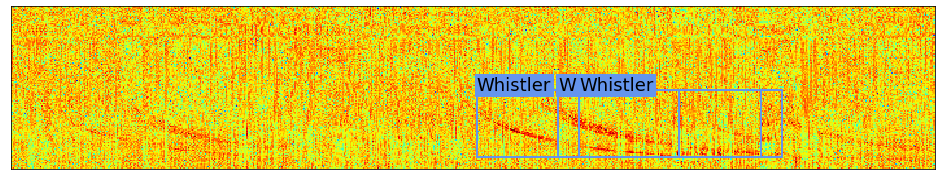

[[0, 0.6137640449438202, 0.7209302325581395, 0.21910112359550563, 0.40310077519379844], [0, 0.702247191011236, 0.7209302325581395, 0.21910112359550563, 0.40310077519379844], [0, 0.7247191011235955, 0.7209302325581395, 0.21910112359550563, 0.40310077519379844], [1, 0.10955056179775281, 0.7209302325581395, 0.21910112359550563, 0.40310077519379844], [1, 0.32865168539325845, 0.7209302325581395, 0.21910112359550563, 0.40310077519379844]]


In [4]:
t, t_params = ['zscore'], [None]
file = database.get_random_sample()
file = '2013-04-22UT01:28:03.48279656.marion.vr2'
print(file)
data, labels = database.load_yolo_file(file,t, t_params)
database.show_yolo_labelled_img(data,labels, rgb=False, noise=False, cmap='jet', font=font)
print(labels)

### Dataset augmentation

**Scale**

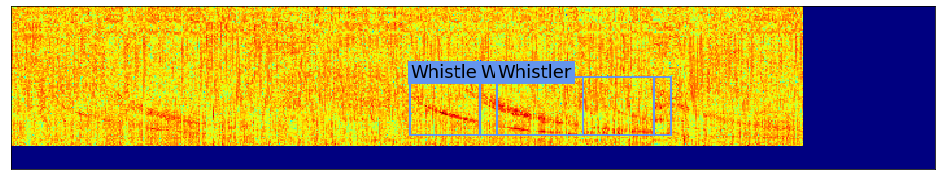

[[0.         0.526719   0.6153603  0.1880278  0.3525849 ]
 [0.         0.60265326 0.6153603  0.18802784 0.3525849 ]
 [0.         0.62193817 0.6153603  0.1880278  0.3525849 ]
 [1.         0.09401391 0.6153603  0.18802781 0.3525849 ]
 [1.         0.28204173 0.6153603  0.18802781 0.3525849 ]]


In [5]:
img, bboxes = yolo_aug.data_aug(file, ['scale'], t, t_params)
bboxes = yolo_aug.bbox_index_to_norm(img, bboxes)
database.show_yolo_labelled_img(img,bboxes, rgb=False, noise=False, cmap='jet', font=font)
print(bboxes)

**Rotate**

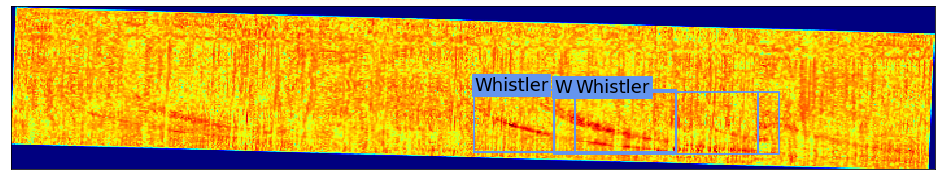

[[0.         0.6116478  0.70357645 0.2203619  0.3798154 ]
 [0.         0.69958144 0.71806467 0.22036195 0.37981546]
 [0.         0.7219138  0.7217442  0.22036195 0.37981546]
 [1.         0.11056573 0.6210169  0.22036196 0.3798154 ]
 [1.         0.32830614 0.6568924  0.22036195 0.37981543]]


In [8]:
img, bboxes = yolo_aug.data_aug(file, ['rotate'], t, t_params)
bboxes = yolo_aug.bbox_index_to_norm(img, bboxes)
database.show_yolo_labelled_img(img,bboxes, rgb=False, noise=False, cmap='jet', font=font)
print(bboxes)

**Mixture**

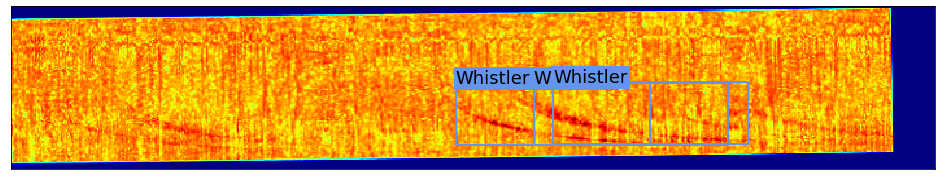

[[0.         0.5873876  0.6697293  0.21024948 0.37983587]
 [0.         0.6718899  0.6635973  0.21024944 0.3798359 ]
 [0.         0.6933509  0.66204005 0.21024953 0.3798359 ]
 [1.         0.10585861 0.7046717  0.2102495  0.3798359 ]
 [1.         0.31510243 0.6894879  0.2102495  0.3798359 ]]


In [10]:
aug_t = ['scale', 'rotate']
img, bboxes = yolo_aug.data_aug(file, aug_t, t, t_params)
bboxes = yolo_aug.bbox_index_to_norm(img, bboxes)
database.show_yolo_labelled_img(img,bboxes, rgb=False, noise=False, cmap='jet', font=font)
print(bboxes)

**Generate Augmented Dataset**

In [ ]:
transforms, transforms_params = [[None], ['zscore'], ['detrend'], ['detrend']],[[None], [None], ['constant'], ['linear']]
transforms, transforms_params = [['zscore']],[[None]]
aug_t = ['rotate', 'scale']
for t, t_params in zip(transforms, transforms_params):
    yolo_aug.generate_yolo_aug(aug_t, t, t_params)
    yolo_aug.yolo_aug_data_split(aug_t, t, t_params)

## **6.3 Knowledge Transfer**

In [5]:
"""
<data> = models/<yolo_models>/cfg/<type>.data
<cfg> = models/<yolo_models>/cfg/model.cfg
<model> = models/<yolo_models>/<yolo_models>

--- freeze layer
./darknet partial <cfg> <model> <new_name> <layer_nbr>

--- training netwrok
./darknet detector train <data>  <cfg> <model> -clear 1

--- predict
./darknet detect <cfg> <model> <image>

--- YOLOv3-tiny
    conv net: 0:15, classifier: 16:
--- YOLOv3-spp
    conv net: 0:88, classifier: 89: 
"""

'\n<data> = models/<yolo_models>/cfg/<type>.data\n<cfg> = models/<yolo_models>/cfg/model.cfg\n<model> = models/<yolo_models>/<yolo_models>\n\n--- freeze layer\n./darknet partial <cfg> <model> <new_name> <layer_nbr>\n\n--- training netwrok\n./darknet detector train <data>  <cfg> <model> -clear 1\n\n--- predict\n./darknet detect <cfg> <model> <image>\n\n--- YOLOv3-tiny\n    conv net: 0:15, classifier: 16:\n--- YOLOv3-spp\n    conv net: 0:88, classifier: 89: \n'

## **6.4 Detector Output**

In [2]:
yolo = YOLODetector()

model_data_type = "real"
model_base = 'yolov3-tiny'
model_name = 'real_fine_tunning'

# yolo.load_model(model_base, model_data_type, model_name)

2013-07-19UT04:14:42.00291922.marion.vr2
[[1.    2.69  3.628 1.152 9.365]
 [0.93  2.239 3.255 1.502 9.156]]


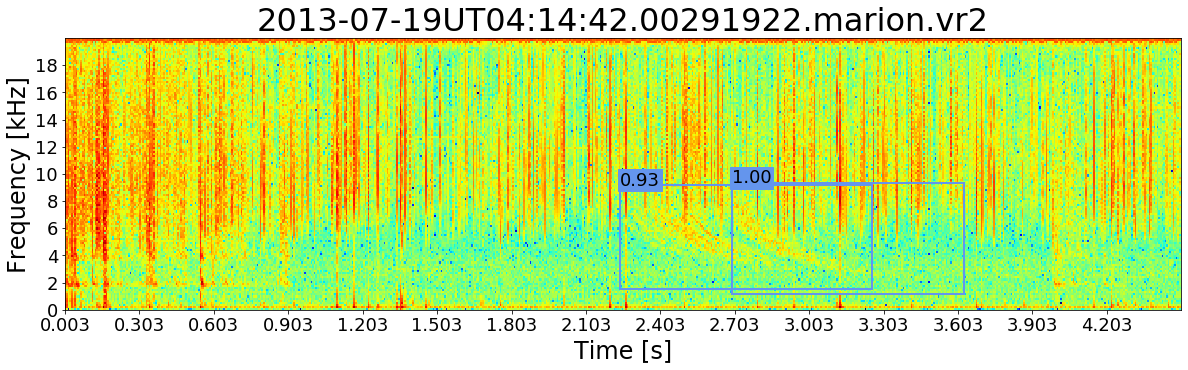

In [6]:
files = database.get_test()
file = np.random.choice(files)
file = '2013-07-19UT04:14:42.00291922.marion.vr2'
print(file)
# transforms, transforms_params = ['zscore'], [None]
transforms, transforms_params = [None], [None]

# model_name = 'real_fine_tunning'
model_name = 'real_transfer_learning'
# model_name = 'real_fine_tunning_zscore'
# for model_name in ['real_fine_tunning','real_transfer_learning']:
yolo.load_model(model_base, model_data_type, model_name)
bboxes = yolo.detection_bounding_boxes(dataset_loc, site, file, transforms, transforms_params,thresh=.2)
print(bboxes)
freq_size = 4
sample = Sample(dataset_loc, site, file)
sample.spectrogram_with_axis(log10=True)
sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size)
sample.spectrogram_plot(figsize=(sample.get_figsize()[0],5) , xlabel='Time [s]', ylabel='Frequency [kHz]',zlabel='sprectrum magnitude [dB]', 
                                   xaxis=True, yaxis=True,ticks=[0.3,2], title=sample.get_file(), cmap='jet', cmap_show=False, font=font,output=bboxes)

In [ ]:
'2013-07-11UT01:07:21.70851938.marion.vr2'
'2013-06-09UT16:29:50.49527109.marion.vr2'
'2013-07-26UT01:24:21.35651914.marion.vr2'
'2013-06-09UT16:03:40.03767109.marion.vr2'
'2013-05-18UT14:00:00.04392156.marion.vr2'
'2013-06-09UT15:00:36.10167109.marion.vr2'